# Notes

Dataset – "Young People Survey" by Miroslav Sabo: https://www.kaggle.com/miroslavsabo/young-people-survey

Link to Data Science Union @UCLA's Cleaned Dataset: https://github.com/the-data-science-union/DSU-W21-Personality/blob/main/cleaned_youngpeople_data.csv

# Importing Packages

In [1]:
# Everything we need to get started
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# For feature selection
from sklearn.feature_selection import RFE

# For hyperparameter tuning
from pprint import pprint
from sklearn.model_selection import GridSearchCV

# For model evaluation
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# Useful Functions

In [2]:
# We will be using this link to access a cleaned version of the Young People Survey by Data Science Union
csvname='https://raw.githubusercontent.com/the-data-science-union/DSU-W21-Personality/main/cleaned_youngpeople_data.csv'

# Loads the entire dataset into X, y
# y includes all six potential response variables
# This function is no longer used...
def load_data(csvname=csvname):
    print('CSV File Path:', csvname)
    df = pd.read_csv(csvname)
    X = df.drop('Education', axis=1)
    y = df['Education'].copy()
    print('Dataset Loaded')
    return X, y

# Loads dataset, but y is transformed into 0s and 1s based on the target response variable
# This is the function we currently use for our dataset and model
def load_binary_data(csvname=csvname, response='secondary school'):
    print('CSV File Path:', csvname)
    df = pd.read_csv(csvname)
    X = df.drop('Education', axis=1)
    print('\nPotential Response Variables:', df['Education'].unique().tolist())
    print('\nSelected Response Variable:', response)
    df.loc[df['Education'] != response, 'Education'] = 0
    df.loc[df['Education'] == response, 'Education'] = 1
    y = df['Education'].copy()
    y = y.astype('int')
    return X, y, df

# Loads the dataset but drops two potential responses, this was an early attempt at combatting class imbalances
# Decided to stop using this function as class imbalance was still a major issue
def load_drop_data(csvname=csvname):  
    print('CSV File Path:', csvname)
    df = pd.read_csv(csvname)
    d_df = df[(df['Education'] != 'currently a primary school pupil') & (df['Education'] != 'doctorate degree')]
    X = d_df.drop('Education', axis=1)
    y = d_df['Education'].copy()
    print('Dataset Loaded')
    return X, y

# Returns a list of the names of the categorical predictors in the dataset
def find_categorical(X):
    catdf = X.loc[:, ~X.columns.isin(X._get_numeric_data().columns)]
    return catdf.columns.values.tolist()

# Sets up a base-line Random Forest for on-the-go evaluation
# Has an optional parameter to plot the model's confusion matrix or only return accuracy score
def quick_forest(select_x, y, plot=True, score=False):
    X_train, X_test, y_train, y_test = train_test_split(select_x, y, test_size=0.3)
    qf = RandomForestClassifier()
    qf.fit(X_train, y_train)
    if score:
        return qf.score(X_test, y_test)
    print('Accuracy Score:', qf.score(X_test, y_test))
    if plot:
        plot_confusion_matrix(qf, X_test, y_test)

# Loading in and Preparing our DataFrame

We start by loading in our data. We obtained this data from Miroslav Sabos' Young People Survey from Kaggle, but we are using a version of it that we (Data Science Union @UCLA) already cleaned. 

The load_binary_data function will load in our data but converts the 'Education' column in our DataFrame from a multi-class categorical variable to a binary variable in order to avoid difficulties with class imbalances. We selected our response variable to be 'secondary school' because it is the mode of the column. In case we need to investigate anything further in our dataset, we also retain a copy of the original DataFrame.

In [3]:
X, y, df = load_binary_data(response='secondary school')
print('Shape of X:', X.shape)
print('Shape of y:', y.shape)

print('\nValue Counts of Response Variable:')
print(y.value_counts())

CSV File Path: https://raw.githubusercontent.com/the-data-science-union/DSU-W21-Personality/main/cleaned_youngpeople_data.csv

Potential Response Variables: ['college/bachelor degree', 'secondary school', 'primary school', 'masters degree', 'doctorate degree', 'currently a primary school pupil']

Selected Response Variable: secondary school
Shape of X: (977, 149)
Shape of y: (977,)

Value Counts of Response Variable:
1    603
0    374
Name: Education, dtype: int64


Because scikit-learn's RandomForestClassifier cannot evalute non-binary categorical nominal data, we are going to find the categorical variables in the DataFrame and convert them to binary datatypes using pandas.get_dummies().

In [4]:
cats = find_categorical(X)
print('Number of Categorical Variables:', len(cats))
print('\nCategoricals:', cats)

X_enc = pd.get_dummies(X, columns=cats)

Number of Categorical Variables: 10

Categoricals: ['Smoking', 'Alcohol', 'Punctuality', 'Lying', 'Internet usage', 'Gender', 'Left - right handed', 'Only child', 'Village - town', 'House - block of flats']


# Baseline RandomForestClassifier

First, let's get a baseline score of the RandomForestClassifier's ability to predict whether a respondent's highest educational attainment is secondary school (high school) or not. It seems like our baseline model has a ~65% accuracy rate, but we have seen it get incredibly high accuracy scores on occasion by random chance.

Accuracy Score: 0.6632653061224489


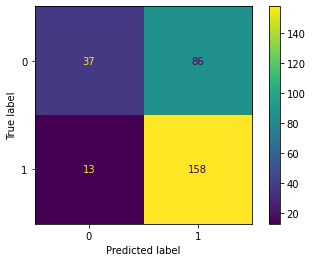

In [5]:
quick_forest(X_enc, y, plot=True)

# Feature Selection with SelectKBest

In [6]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# use chi-squared statistical test to select 20 of the best features
bestfeatures = SelectKBest(score_func=chi2, k=20)
fit = bestfeatures.fit(X_enc, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_enc.columns)

# Prepare df for easy-reading
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']

In [7]:
trials = 30
chi_scores = dict()

# Select how many k-best to incorporate in the training set
for k in range(12, 21):
    best_k = featureScores.nlargest(k,'Score')
    X_chi_select = X_enc.loc[:, best_k['Specs'].values]
    chi_select_scores = [quick_forest(X_chi_select, y, score=True) for i in range(trials)]
    print('\n# of Features:', k)
    print('Mean Accuracy:', np.mean(chi_select_scores))
    print('Std:', np.std(chi_select_scores))
    chi_scores[np.mean(chi_select_scores)] = best_k['Specs'].values.tolist()


# of Features: 12
Mean Accuracy: 0.6772108843537414
Std: 0.018324254480076553

# of Features: 13
Mean Accuracy: 0.687641723356009
Std: 0.022079752941213684

# of Features: 14
Mean Accuracy: 0.683673469387755
Std: 0.025769655680103146

# of Features: 15
Mean Accuracy: 0.6892290249433105
Std: 0.022364358709673723

# of Features: 16
Mean Accuracy: 0.6935374149659864
Std: 0.026657496456487753

# of Features: 17
Mean Accuracy: 0.7024943310657596
Std: 0.018099443131798093

# of Features: 18
Mean Accuracy: 0.6998866213151926
Std: 0.024428042153919246

# of Features: 19
Mean Accuracy: 0.6942176870748299
Std: 0.019859402145571442

# of Features: 20
Mean Accuracy: 0.6924036281179137
Std: 0.018788390971995483


In [8]:
best_chi_score = np.max(list(chi_scores.keys()))
best_chi_feats = chi_scores[best_chi_score]
print('Mean Score of {} Trials for {} Selected Features: {}\n'.format(trials, len(best_chi_feats), best_chi_score))
print(best_chi_feats)

Mean Score of 30 Trials for 17 Selected Features: 0.7024943310657596

['Age', 'Charity', 'Number of siblings', 'Biology', 'Cheating in school', 'Adrenaline sports', 'Storm', 'Hypochondria', 'Active sport', 'Passive sport', 'Folk', 'Workaholism', 'Art exhibitions', 'Alcohol_never', 'Alternative', 'Rats', 'Internet usage_most of the day']


# Feature Selection with RFE

Although Random Forests tend to produce reasonable predictions given a large volume of data, we will try Recursive Feature Elimination to hone our accuracy before moving on to hyperparameter tuning.

In [9]:
feature_groups = list()
rf = RandomForestClassifier()
for i in range(12, 19):
    selector = RFE(rf, n_features_to_select=i, step=1)
    selector.fit(X_enc, y)
    X_RFE = X_enc.loc[:, selector.support_]
    print('\n# of Features:', i)
    feats = X_RFE.columns.values.tolist()
    print(feats)
    feature_groups.append(feats)


# of Features: 12
['Pop', 'Reggae, Ska', 'War', 'History', 'Theatre', 'Dangerous dogs', 'Changing the past', 'New environment', 'Entertainment spending', 'Age', 'Height', 'Weight']

# of Features: 13
['Reggae, Ska', 'Rock n roll', 'Sci-fi', 'History', 'Psychology', 'Art exhibitions', 'Adrenaline sports', 'Cheating in school', 'Changing the past', 'New environment', 'Age', 'Height', 'Weight']

# of Features: 14
['Reggae, Ska', 'Alternative', 'History', 'Biology', 'Art exhibitions', 'Adrenaline sports', 'Prioritising workload', 'Cheating in school', 'Changing the past', 'Getting angry', 'Small - big dogs', 'Age', 'Height', 'Weight']

# of Features: 15
['Dance', 'Reggae, Ska', 'War', 'History', 'Biology', 'Art exhibitions', 'Passive sport', 'Adrenaline sports', 'Workaholism', 'Elections', 'New environment', 'Entertainment spending', 'Age', 'Height', 'Weight']

# of Features: 16
['Pop', 'Reggae, Ska', 'Alternative', 'Action', 'History', 'Biology', 'Adrenaline sports', 'Writing notes', 'Wo

In [10]:
trials = 10
rfe_scores = dict()

print('Number of Trials:', trials)

base_scores = [quick_forest(X_enc, y, score=True) for i in range(trials)]
# print(("\nBaseline Accuracy: ["+', '.join(['%.3f']*trials)+"]") % tuple(base_scores))
print('Baseline Mean Accuracy:', np.mean(base_scores))
print('Baseline Std:', np.std(base_scores))
print('–'*25)

for cols in feature_groups:
    test_rfe = X_enc.loc[:, cols]
    test_scores = [quick_forest(test_rfe, y, score=True) for i in range(trials)]
    print('\nNumber of Features:', len(cols))
#     print(("Accuracy Scores: ["+', '.join(['%.3f']*trials)+"]") % tuple(test_scores))
    print('Mean Accuracy:', np.mean(test_scores))
    print('Std:', np.std(test_scores))
    rfe_scores[np.mean(test_scores)] = cols

Number of Trials: 10
Baseline Mean Accuracy: 0.6615646258503401
Baseline Std: 0.020703643256507746
–––––––––––––––––––––––––

Number of Features: 12
Mean Accuracy: 0.6714285714285714
Std: 0.019491903104618243

Number of Features: 13
Mean Accuracy: 0.6867346938775512
Std: 0.01757223313345508

Number of Features: 14
Mean Accuracy: 0.6717687074829931
Std: 0.031294365517718276

Number of Features: 15
Mean Accuracy: 0.7030612244897959
Std: 0.01900201050811352

Number of Features: 16
Mean Accuracy: 0.6901360544217687
Std: 0.013472994775740396

Number of Features: 17
Mean Accuracy: 0.6874149659863946
Std: 0.023782783818249466

Number of Features: 18
Mean Accuracy: 0.673469387755102
Std: 0.028294740602837317


In [11]:
best_rfe_score = np.max(list(rfe_scores.keys()))
best_rfe_feats = rfe_scores[np.max(list(rfe_scores.keys()))]
print('Mean Score of {} Trials for {} Selected Features: {}\n'.format(trials, len(best_rfe_feats), best_rfe_score))
print(best_rfe_feats)

Mean Score of 10 Trials for 15 Selected Features: 0.7030612244897959

['Dance', 'Reggae, Ska', 'War', 'History', 'Biology', 'Art exhibitions', 'Passive sport', 'Adrenaline sports', 'Workaholism', 'Elections', 'New environment', 'Entertainment spending', 'Age', 'Height', 'Weight']


# Hyperparameter Tuning

We will be using GridSearchCV to tune our hyperparameters, comparing the best parameters of the search with our baseline model score from before.

In [12]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.arange(100, 251, 50)]
# Criterion for scoring
criterion = ['gini', 'entropy']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.arange(3, 7, 1)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.arange(2, 5, 1)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4]
# Method of selecting samples for training each tree
# bootstrap = [True, False]
# Create the random grid
par_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap,
               'criterion': criterion}
pprint(par_grid)

{'criterion': ['gini', 'entropy'],
 'max_depth': [3, 4, 5, 6, None],
 'min_samples_leaf': [1, 2, 3, 4],
 'min_samples_split': [2, 3, 4],
 'n_estimators': [100, 150, 200, 250]}


I've decided to use GridSearchCV on the 20 best features selected by the Chi-Squared test.

In [13]:
selected_X = X_enc.loc[:, best_chi_feats]
# selected_X = X_enc.loc[:, best_rfe_feats]
X_train, X_test, y_train, y_test = train_test_split(selected_X, y, test_size=0.3)
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = par_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [14]:
# Fit the Model...
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:  2.2min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, None],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [100, 150, 200, 250]},
             verbose=2)

In [15]:
# Let's look at our best parameters...
grid_search.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 250}

In [16]:
totsc = list()
for i in range(50):
    best_grid = grid_search.best_estimator_
    X_train, X_test, y_train, y_test = train_test_split(selected_X, y, test_size=0.3)
    best_grid.fit(X_train, y_train)
    totsc.append(best_grid.score(X_test, y_test))
print('Mean Accuracy:', np.mean(totsc))
print('Std:', np.std(totsc))
print('Highest:', np.max(totsc))

Mean Accuracy: 0.7039455782312927
Std: 0.020822994796962188
Highest: 0.7482993197278912


In [17]:
base_sc = list()
base_rf = RandomForestClassifier()
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.3)
    base_rf.fit(X_train, y_train)
    base_sc.append(base_rf.score(X_test, y_test))
print('Mean Accuracy:', np.mean(base_sc))
print('Std:', np.std(base_sc))
print('Highest:', np.max(base_sc))

Mean Accuracy: 0.6654421768707484
Std: 0.021249766912289778
Highest: 0.7108843537414966


Accuracy Score: 0.6972789115646258


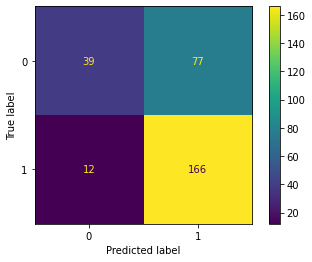

In [22]:
best_grid = grid_search.best_estimator_
X_train, X_test, y_train, y_test = train_test_split(selected_X, y, test_size=0.3)
best_grid.fit(X_train, y_train)
print('Accuracy Score:', best_grid.score(X_test, y_test))
plot_confusion_matrix(best_grid, X_test, y_test)

Accuracy Score: 0.6666666666666666


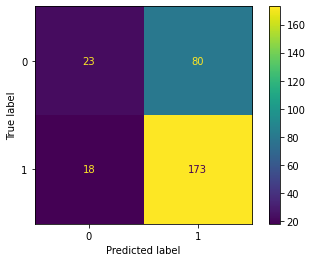

In [23]:
base_rf = RandomForestClassifier()
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.3)
base_rf.fit(X_train, y_train)
print('Accuracy Score:', base_rf.score(X_test, y_test))
plot_confusion_matrix(base_rf, X_test, y_test)

# Evaluating with RepeatedKFold Cross Validation

In [24]:
cv = RepeatedKFold(n_splits=10, n_repeats=50)

base_rf = RandomForestClassifier()

# evaluate base-line model
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.3)
scores = cross_val_score(base_rf, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Base-line Random Forest')
pprint(base_rf.get_params())
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Base-line Random Forest
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}
Accuracy: 0.626 (0.086)


In [25]:
cv = RepeatedKFold(n_splits=10, n_repeats=50)

# evaluate final model
X_train, X_test, y_train, y_test = train_test_split(selected_X, y, test_size=0.3)
scores = cross_val_score(best_grid, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Final Random Forest')
pprint(grid_search.best_params_)
print('\nAccuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Final Random Forest
{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 250}

Accuracy: 0.676 (0.089)


# Final Results

## Baseline Random Forest
In 50 Trials – Mean Accuracy: 0.6654421768707484 /// Std: 0.021249766912289778 /// Highest: 0.7108843537414966

Tenfold Cross Validation – Accuracy 0.626 /// Std: 0.086

## Tuned Random Forest
In 50 Trials – Mean Accuracy: 0.7039455782312927 /// Std: 0.020822994796962188 /// Highest: 0.7482993197278912

Tenfold Cross Validation – Accuracy: 0.676 // Std: 0.089